# Отбор релевантных дат

0. Считаем сумму по частотности упоминаний нграм
1. Считаем относительные частоты
2. Считаем разницу между относительными частотами за пары лет и оставляем только положительную (положительная разница означает рост числа вхождений); оставляем в датафрейме только те нграмы, у которых частотность больше 40 (остальное точно шум). В принципе, уже по положительной разнице частот можно выделить даты, на которые приходится период роста частотности. Но иногда рост может быть совсем небольшой, хотя и регулярный, поэтому попробуем найти еще и точки (=годы), на которые приходится максимальный прирост частотности. Это могут быть и отдельные годы, и годы, которые попадают в какой-либо период роста.  
3. Для этого нормируем относительные частоты (z-score). Находим годы, когда рост относительной частотности самый выраженный и не случайный (т.е, когда z-score выходит за 1.65 на 5%-ном уровне значимости (*или все же лучше взять +-1.96 и потом отфильтровать положительные значения? Тогда "выбросов" будет меньше* ). При этом допускаем, что значения роста частотности имеют нормальное распределение. Однако, на мой взгляд, из-за того, что частотность сильно скачет, дисперсия получается слишком большой, в результате нулевая гипотеза очень редко отклоняется и на выходе мы получаем слишком мало точек (дат) для каждой нграмы, которые могут быть интересны. 
4. Поэтому уменьшаем дисперсию, взяв z-score от скользящего среднего за 5 лет. Сам график относительной частотности получается сглаженнее, дисперсия сокращается, поэтому больше точек выглядят интересными. 
5. Сохраняем в словарь итоговые даты для конкретных нграм: это будут как отдельные точки максимального прироста, так и периоды, когда начинается и кончается рост частотности. 

### Что еще, возможно, можно сделать: брать разницу не каждых двух лет (текущий год - предыдущий), а, например, 5-ти. Пока мне это не кажется целесообразным

# 0. Сумма частот упоминаний нграм

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale

In [8]:
df = pd.read_pickle("norm-unigrams_d.pkl")
df.reset_index(inplace = True)
df.head()

,unigram,year,page_count,volume_count
0,д'6йств1я,1930,2,1
1,д'6йств1я,1968,2,2
2,д'а,1918,1,1
3,д'а,1920,2,1
4,д'а,1922,4,4


In [9]:
df_new = df.groupby(['unigram', 'year']).page_count.sum().unstack().reset_index()

In [10]:
df_new.head()

year,unigram,1918,1919,1920,1921,1922,1923,1924,1925,1926,...,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
0,д'6йств1я,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,д'а,1.0,NaN,2.0,NaN,4.0,1.0,NaN,3.0,14.0,...,12.0,7.0,19.0,18.0,8.0,3.0,4.0,31.0,12.0,1.0
2,д'абано,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,...,1.0,3.0,2.0,1.0,3.0,1.0,4.0,3.0,NaN,NaN
3,д'аббадя,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
4,д'абернон,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3.0,NaN,...,3.0,5.0,3.0,22.0,9.0,4.0,5.0,8.0,9.0,11.0


In [11]:
df.unigram.nunique()

79269

In [12]:
df_new = df_new.fillna(0)

In [13]:
df_new['freq_sum'] = df_new.iloc[:,1:].sum(axis=1)

In [14]:
max(df_new['freq_sum'])

224808916.0

In [15]:
min(df_new['freq_sum'])

1.0

# 1. Относительные частоты

In [16]:
rel_count = pd.read_csv('relative_frequences.csv')
rel_count = rel_count[rel_count.year > 1917]
rel_freq_list = list(rel_count.match_count)

In [17]:
relative_counts = df_new.iloc[:, 1:-1] / rel_freq_list * 10000

In [18]:
relative_counts.head()

year,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,...,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
0,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.00039,0.0,0.000745,0.0,0.000519,0.000088,0.0,0.000275,0.001155,0.000573,...,0.000107,0.000064,0.000176,0.000155,0.000071,0.000027,0.000040,0.000360,0.000154,0.000021
2,0.00000,0.0,0.000000,0.0,0.000000,0.000176,0.0,0.000000,0.000000,0.000000,...,0.000009,0.000027,0.000019,0.000009,0.000027,0.000009,0.000040,0.000035,0.000000,0.000000
3,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000082,0.000000,...,0.000000,0.000009,0.000000,0.000000,0.000000,0.000000,0.000040,0.000000,0.000000,0.000000
4,0.00000,0.0,0.000000,0.0,0.000130,0.000000,0.0,0.000275,0.000000,0.000000,...,0.000027,0.000046,0.000028,0.000190,0.000080,0.000037,0.000051,0.000093,0.000115,0.000234


In [19]:
for i in relative_counts:
    df_new[i] = relative_counts[i]

In [20]:
# df_sorted_by_freq = df_new.sort_values('freq_sum', ascending=False)
# df_sorted_by_freq[(df_sorted_by_freq["freq_sum"] > 300) & (df_sorted_by_freq["freq_sum"] < 400)]

In [21]:
result_df = df_new[df_new["freq_sum"] > 40] 
len(result_df)
# возьмем 40 как минимальное число нграм (match_count) 
# ниже этого порога встречается много шума
# и вряд ли будет интересная статистика

65529

In [22]:
result_df.head(5)

year,unigram,1918,1919,1920,1921,1922,1923,1924,1925,1926,...,2001,2002,2003,2004,2005,2006,2007,2008,2009,freq_sum
1,д'а,0.00039,0.0,0.000745,0.0,0.000519,0.000088,0.0,0.000275,0.001155,...,0.000064,0.000176,0.000155,0.000071,0.000027,0.000040,0.000360,0.000154,0.000021,1663.0
2,д'абано,0.00000,0.0,0.000000,0.0,0.000000,0.000176,0.0,0.000000,0.000000,...,0.000027,0.000019,0.000009,0.000027,0.000009,0.000040,0.000035,0.000000,0.000000,117.0
3,д'аббадя,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000082,...,0.000009,0.000000,0.000000,0.000000,0.000000,0.000040,0.000000,0.000000,0.000000,184.0
4,д'абернон,0.00000,0.0,0.000000,0.0,0.000130,0.000000,0.0,0.000275,0.000000,...,0.000046,0.000028,0.000190,0.000080,0.000037,0.000051,0.000093,0.000115,0.000234,2111.0
5,д'абор,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000037,0.000000,0.000009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,110.0


In [23]:
result_df = result_df.sort_values('freq_sum', ascending=False).reset_index()

In [24]:
result_df.head(10)

year,index,unigram,1918,1919,1920,1921,1922,1923,1924,1925,...,2001,2002,2003,2004,2005,2006,2007,2008,2009,freq_sum
0,45054,для,39.036406,39.355981,36.372634,35.476594,34.023851,33.740838,37.896171,34.679782,...,30.450889,31.228442,30.769973,30.621972,30.345128,30.883207,30.777979,29.839784,29.342707,224808916.0
1,68576,другой,19.031174,19.297703,18.592957,16.949021,16.869017,16.611967,17.831832,16.571343,...,14.730028,14.796463,14.790843,14.778867,14.222450,14.689135,14.484805,14.451360,14.647160,92584621.0
2,9525,два,8.341882,8.264890,8.991126,8.710963,9.227572,8.790971,9.350855,9.172807,...,8.763922,8.621387,8.694651,8.843006,8.749081,8.723851,8.684844,8.544551,8.314772,56219235.0
3,20541,дело,6.705325,10.762902,11.255200,8.842531,10.091635,12.599735,12.049824,12.249937,...,9.671986,10.218752,10.067804,10.160027,9.461811,9.843108,9.657113,10.075953,10.097512,52091655.0
4,1844,давать,11.391955,11.890359,10.956178,10.861228,11.049199,11.460628,11.228082,11.956199,...,6.719774,6.570329,6.668158,6.671249,6.569961,6.617899,6.591035,6.622297,6.544271,47745305.0
5,23276,день,10.382803,8.388227,8.896914,11.169012,10.801509,9.729163,9.436660,9.416135,...,7.793167,7.717343,7.894914,8.018357,8.123143,8.022896,8.130827,7.906787,8.460015,45001150.0
6,54566,должный,9.783083,11.543587,11.356115,10.138132,9.313421,9.337810,10.525374,9.148291,...,5.960827,6.306308,6.357899,6.197153,5.944215,6.209921,6.305711,6.595834,6.330179,38496443.0
7,3188,даже,11.270685,10.326309,10.171572,9.779887,9.499124,9.003244,7.580600,7.931928,...,6.628720,6.534657,6.753633,6.886018,6.954921,7.093802,7.202829,7.397677,7.299578,35552805.0
8,6322,данный,1.308622,2.261170,2.674809,1.979332,2.782303,3.094202,3.737497,3.923543,...,4.373443,4.584335,4.491072,4.546810,4.371363,4.469507,4.482024,4.320842,4.075861,30223713.0
9,68274,друг,6.017479,6.182915,6.655928,6.270879,6.062321,6.126334,5.079186,5.139079,...,5.270537,5.071862,5.146346,5.217373,5.265329,5.311799,5.331990,5.466154,5.484496,29815544.0


# 2. Разница между относительными частотами

In [25]:
rel_diff = result_df.iloc[:,2:-1].diff(axis=1)

In [26]:
rel_diff.head() 
# из значения года вычитается значение предыдущего

year,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,...,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
0,NaN,0.319575,-2.983347,-0.896040,-1.452744,-0.283013,4.155333,-3.216388,2.466745,-2.737176,...,-0.120086,-0.631034,0.777553,-0.458469,-0.148002,-0.276844,0.538079,-0.105228,-0.938196,-0.497077
1,NaN,0.266529,-0.704746,-1.643935,-0.080004,-0.257050,1.219865,-1.260489,-0.919096,0.453908,...,0.239431,-0.258660,0.066436,-0.005621,-0.011976,-0.556417,0.466685,-0.204330,-0.033445,0.195801
2,NaN,-0.076992,0.726236,-0.280163,0.516609,-0.436601,0.559884,-0.178048,0.535788,-0.679648,...,0.132025,-0.013401,-0.142535,0.073264,0.148355,-0.093925,-0.025230,-0.039007,-0.140293,-0.229779
3,NaN,4.057578,0.492297,-2.412668,1.249104,2.508099,-0.549911,0.200113,-1.321169,1.217871,...,0.631392,-0.718638,0.546767,-0.150948,0.092223,-0.698216,0.381297,-0.185994,0.418839,0.021559
4,NaN,0.498404,-0.934181,-0.094950,0.187971,0.411429,-0.232546,0.728117,0.196618,0.026428,...,0.139417,-0.176162,-0.149445,0.097829,0.003091,-0.101288,0.047938,-0.026864,0.031263,-0.078026


In [27]:
positive_rel_diff = rel_diff[rel_diff.iloc[:, :] > 0]
positive_rel_diff.head()

year,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,...,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
0,NaN,0.319575,NaN,NaN,NaN,NaN,4.155333,NaN,2.466745,NaN,...,NaN,NaN,0.777553,NaN,NaN,NaN,0.538079,NaN,NaN,NaN
1,NaN,0.266529,NaN,NaN,NaN,NaN,1.219865,NaN,NaN,0.453908,...,0.239431,NaN,0.066436,NaN,NaN,NaN,0.466685,NaN,NaN,0.195801
2,NaN,NaN,0.726236,NaN,0.516609,NaN,0.559884,NaN,0.535788,NaN,...,0.132025,NaN,NaN,0.073264,0.148355,NaN,NaN,NaN,NaN,NaN
3,NaN,4.057578,0.492297,NaN,1.249104,2.508099,NaN,0.200113,NaN,1.217871,...,0.631392,NaN,0.546767,NaN,0.092223,NaN,0.381297,NaN,0.418839,0.021559
4,NaN,0.498404,NaN,NaN,0.187971,0.411429,NaN,0.728117,0.196618,0.026428,...,0.139417,NaN,NaN,0.097829,0.003091,NaN,0.047938,NaN,0.031263,NaN


In [28]:
new_df = pd.concat([result_df.iloc[:, 0:2], positive_rel_diff, result_df.iloc[:, -1]], axis=1)
new_df.head(10)

,index,unigram,1918,1919,1920,1921,1922,1923,1924,1925,...,2001,2002,2003,2004,2005,2006,2007,2008,2009,freq_sum
0,45054,для,NaN,0.319575,NaN,NaN,NaN,NaN,4.155333,NaN,...,NaN,0.777553,NaN,NaN,NaN,0.538079,NaN,NaN,NaN,224808916.0
1,68576,другой,NaN,0.266529,NaN,NaN,NaN,NaN,1.219865,NaN,...,NaN,0.066436,NaN,NaN,NaN,0.466685,NaN,NaN,0.195801,92584621.0
2,9525,два,NaN,NaN,0.726236,NaN,0.516609,NaN,0.559884,NaN,...,NaN,NaN,0.073264,0.148355,NaN,NaN,NaN,NaN,NaN,56219235.0
3,20541,дело,NaN,4.057578,0.492297,NaN,1.249104,2.508099,NaN,0.200113,...,NaN,0.546767,NaN,0.092223,NaN,0.381297,NaN,0.418839,0.021559,52091655.0
4,1844,давать,NaN,0.498404,NaN,NaN,0.187971,0.411429,NaN,0.728117,...,NaN,NaN,0.097829,0.003091,NaN,0.047938,NaN,0.031263,NaN,47745305.0
5,23276,день,NaN,NaN,0.508687,2.272098,NaN,NaN,NaN,NaN,...,NaN,NaN,0.177571,0.123443,0.104786,NaN,0.107931,NaN,0.553228,45001150.0
6,54566,должный,NaN,1.760504,NaN,NaN,NaN,0.024389,1.187564,NaN,...,NaN,0.345481,0.051591,NaN,NaN,0.265706,0.095790,0.290123,NaN,38496443.0
7,3188,даже,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351329,...,0.005431,NaN,0.218976,0.132386,0.068903,0.138881,0.109027,0.194848,NaN,35552805.0
8,6322,данный,NaN,0.952548,0.413639,NaN,0.802971,0.311899,0.643295,0.186045,...,0.108574,0.210892,NaN,0.055738,NaN,0.098144,0.012516,NaN,NaN,30223713.0
9,68274,друг,NaN,0.165436,0.473013,NaN,NaN,0.064012,NaN,0.059892,...,0.031745,NaN,0.074483,0.071027,0.047956,0.046470,0.020191,0.134164,0.018342,29815544.0


# 3. Пики роста

In [29]:
# добавим колонку среднего значения прироста частотности и его стандартного отклонения
new_df["mean_positive_rel_diff"] = new_df.iloc[:,2:-1].mean(axis=1, numeric_only=True)
new_df["std_positive_rel_diff"] = new_df.iloc[:,2:-2].std(axis=1,ddof=0,numeric_only=True)

In [24]:
new_df.head()

,index,unigram,1918,1919,1920,1921,1922,1923,1924,1925,...,2003,2004,2005,2006,2007,2008,2009,freq_sum,mean_positive_rel_diff,std_positive_rel_diff
0,45054,для,NaN,0.319575,NaN,NaN,NaN,NaN,4.155333,NaN,...,NaN,NaN,NaN,0.538079,NaN,NaN,NaN,224808916.0,1.048372,0.888684
1,68576,другой,NaN,0.266529,NaN,NaN,NaN,NaN,1.219865,NaN,...,NaN,NaN,NaN,0.466685,NaN,NaN,0.195801,92584621.0,0.337642,0.289301
2,9525,два,NaN,NaN,0.726236,NaN,0.516609,NaN,0.559884,NaN,...,0.073264,0.148355,NaN,NaN,NaN,NaN,NaN,56219235.0,0.225939,0.202171
3,20541,дело,NaN,4.057578,0.492297,NaN,1.249104,2.508099,NaN,0.200113,...,NaN,0.092223,NaN,0.381297,NaN,0.418839,0.021559,52091655.0,0.557985,0.716622
4,1844,давать,NaN,0.498404,NaN,NaN,0.187971,0.411429,NaN,0.728117,...,0.097829,0.003091,NaN,0.047938,NaN,0.031263,NaN,47745305.0,0.195666,0.191800


In [31]:
# считаем z_scores
z_scores = new_df.iloc[:, 2:-3].apply(lambda ngram: 
                                             scale(ngram,
                                                   axis=0,
                                                   with_mean=True, 
                                                   with_std=True,
                                                   copy=False),
                                             axis=1)

In [32]:
z_scores[0]

array([        nan, -0.82008617,         nan,         nan,         nan,
               nan,  3.49613877,         nan,  1.59603852,         nan,
               nan,  1.70891769, -0.19823762,  0.02287979, -0.63088921,
               nan, -0.37231744, -0.29121959, -0.39843364,         nan,
        0.35820031,         nan, -0.09348205,         nan,         nan,
        1.69709885,         nan,  1.4986051 ,         nan,         nan,
        0.46460588,  0.432578  ,         nan,         nan, -1.12617886,
        1.62004665, -0.59504628,         nan,         nan,         nan,
       -0.5128686 ,  1.85776033, -0.63448812, -0.20718128,         nan,
               nan, -0.30131005,         nan, -0.98427445,         nan,
               nan,         nan,         nan, -0.44231503,  0.29308182,
               nan, -1.07233073, -1.01442282,         nan, -0.6966907 ,
               nan, -0.46380796,         nan,         nan, -0.86355738,
       -1.06268667,         nan,         nan, -0.27300652, -0.53

In [33]:
z_scores_df = pd.DataFrame.from_records(z_scores, columns = [str(i) for i in range(1918, 2009 + 1)])

In [34]:
z_scores_df.head()

,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,...,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
0,NaN,-0.820086,NaN,NaN,NaN,NaN,3.496139,NaN,1.596039,NaN,...,NaN,NaN,-0.304741,NaN,NaN,NaN,-0.574212,NaN,NaN,NaN
1,NaN,-0.245810,NaN,NaN,NaN,NaN,3.049495,NaN,NaN,0.401887,...,-0.339477,NaN,-0.937451,NaN,NaN,NaN,0.446051,NaN,NaN,-0.490289
2,NaN,NaN,2.474626,NaN,1.437744,NaN,1.651797,NaN,1.532609,NaN,...,-0.464525,NaN,NaN,-0.755174,-0.383750,NaN,NaN,NaN,NaN,NaN
3,NaN,4.883458,-0.091663,NaN,0.964413,2.721260,NaN,-0.499387,NaN,0.920829,...,0.102434,NaN,-0.015655,NaN,-0.649941,NaN,-0.246557,NaN,-0.194170,-0.748548
4,NaN,1.578403,NaN,NaN,-0.040119,1.124932,NaN,2.776070,0.004965,-0.882364,...,-0.293267,NaN,NaN,-0.510099,-1.004036,NaN,-0.770218,NaN,-0.857158,NaN


In [35]:
z_scores_df = z_scores_df[z_scores_df > 1.65] 
# если предполагаем, что значени роста частотности имеют нормальное распределение (но тогда много отсеивается)

In [36]:
z_scores_df.head()

,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,...,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
0,NaN,NaN,NaN,NaN,NaN,NaN,3.496139,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,3.049495,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2.474626,NaN,NaN,NaN,1.651797,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,4.883458,NaN,NaN,NaN,2.72126,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.77607,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
new_df_with_z_scores = pd.concat([new_df.iloc[:, 0:2], z_scores_df, new_df.iloc[:, -3:]], axis = 1)

In [38]:
new_df_with_z_scores.head()

,index,unigram,1918,1919,1920,1921,1922,1923,1924,1925,...,2003,2004,2005,2006,2007,2008,2009,freq_sum,mean_positive_rel_diff,std_positive_rel_diff
0,45054,для,NaN,NaN,NaN,NaN,NaN,NaN,3.496139,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,224808916.0,1.048372,0.888684
1,68576,другой,NaN,NaN,NaN,NaN,NaN,NaN,3.049495,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92584621.0,0.337642,0.289301
2,9525,два,NaN,NaN,2.474626,NaN,NaN,NaN,1.651797,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56219235.0,0.225939,0.202171
3,20541,дело,NaN,4.883458,NaN,NaN,NaN,2.72126,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52091655.0,0.557985,0.716622
4,1844,давать,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.77607,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47745305.0,0.195666,0.191800


Text(0.5, 1.0, 'демографический')

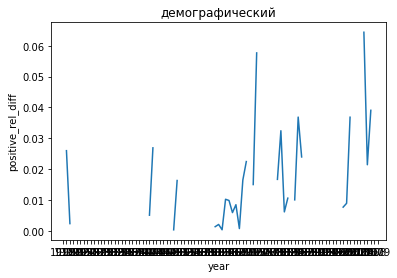

In [39]:
# разница
plt.plot(new_df.iloc[250, 2:-3])
plt.xlabel('year')
plt.ylabel('positive_rel_diff')
plt.title(new_df.iloc[250, 1])

Text(0.5, 1.0, 'демографический')

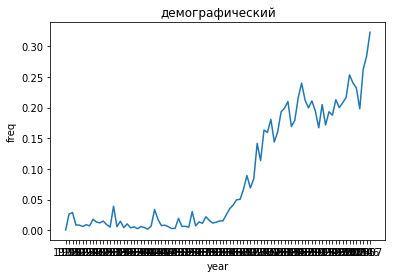

In [40]:
# просто относительные частоты
plt.plot(result_df.iloc[250, 2:-3])
plt.xlabel('year')
plt.ylabel('freq')
plt.title(result_df.iloc[250, 1])

Text(0.5, 1.0, 'демографический')

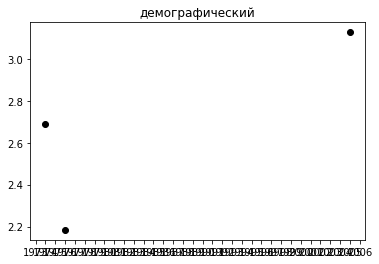

In [41]:
# отклонения от среднего

plt.plot(new_df_with_z_scores.iloc[250,2:-3], 'o', color='black')
plt.title(new_df_with_z_scores.iloc[250, 1])

In [42]:
# самый большой рост
for i in z_scores_df.iloc[250,:]:
    if i:
        print(i)
        
# print(new_df.iloc[0, 2:-3])

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
2.6897358019713553
nan
2.1839577581967755
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
3.1271484133240532
nan
nan
nan
nan


# 4. Скользящее среднее

In [44]:
result_df.head(5)

year,index,unigram,1918,1919,1920,1921,1922,1923,1924,1925,...,2001,2002,2003,2004,2005,2006,2007,2008,2009,freq_sum
0,45054,для,39.036406,39.355981,36.372634,35.476594,34.023851,33.740838,37.896171,34.679782,...,30.450889,31.228442,30.769973,30.621972,30.345128,30.883207,30.777979,29.839784,29.342707,224808916.0
1,68576,другой,19.031174,19.297703,18.592957,16.949021,16.869017,16.611967,17.831832,16.571343,...,14.730028,14.796463,14.790843,14.778867,14.222450,14.689135,14.484805,14.451360,14.647160,92584621.0
2,9525,два,8.341882,8.264890,8.991126,8.710963,9.227572,8.790971,9.350855,9.172807,...,8.763922,8.621387,8.694651,8.843006,8.749081,8.723851,8.684844,8.544551,8.314772,56219235.0
3,20541,дело,6.705325,10.762902,11.255200,8.842531,10.091635,12.599735,12.049824,12.249937,...,9.671986,10.218752,10.067804,10.160027,9.461811,9.843108,9.657113,10.075953,10.097512,52091655.0
4,1844,давать,11.391955,11.890359,10.956178,10.861228,11.049199,11.460628,11.228082,11.956199,...,6.719774,6.570329,6.668158,6.671249,6.569961,6.617899,6.591035,6.622297,6.544271,47745305.0


In [45]:
window_mean = result_df.iloc[:, 2:-1].rolling(window=5, axis=1).mean()

In [47]:
window_mean_df = pd.concat([result_df.iloc[:, 0:2], window_mean, result_df.iloc[:, -1]], axis=1)
window_mean_df.head()

,index,unigram,1918,1919,1920,1921,1922,1923,1924,1925,...,2001,2002,2003,2004,2005,2006,2007,2008,2009,freq_sum
0,45054,для,NaN,NaN,NaN,NaN,36.853093,35.793980,35.502018,35.163447,...,31.204589,31.085525,30.946647,30.830640,30.683281,30.769745,30.679652,30.493614,30.237761,224808916.0
1,68576,другой,NaN,NaN,NaN,NaN,18.147974,17.664133,17.370959,16.966636,...,14.869269,14.813747,14.811056,14.816978,14.663730,14.655552,14.593220,14.525323,14.498982,92584621.0
2,9525,два,NaN,NaN,NaN,NaN,8.707287,8.797105,9.014298,9.050634,...,8.848283,8.747339,8.700516,8.740058,8.734409,8.726395,8.739087,8.709067,8.603420,56219235.0
3,20541,дело,NaN,NaN,NaN,NaN,9.531519,10.710401,10.967785,11.166732,...,9.741523,9.895829,10.021680,10.101839,9.916076,9.950300,9.837973,9.839602,9.827099,52091655.0
4,1844,давать,NaN,NaN,NaN,NaN,11.229784,11.243518,11.111063,11.311067,...,6.847223,6.763712,6.722143,6.705089,6.639894,6.619519,6.623660,6.614488,6.589093,47745305.0


Text(0.5, 1.0, 'демографический')

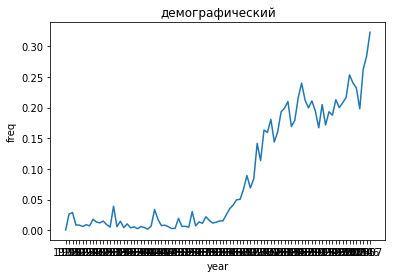

In [48]:
# относительные частоты
plt.plot(result_df.iloc[250, 2:-3])
plt.xlabel('year')
plt.ylabel('freq')
plt.title(result_df.iloc[250, 1])

Text(0.5, 1.0, 'демографический')

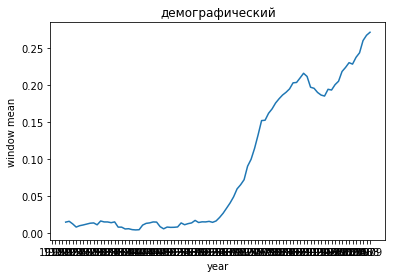

In [50]:
# относительные частоты со скользящим средним
plt.plot(window_mean_df.iloc[250, 2:-1])
plt.xlabel('year')
plt.ylabel('window mean')
plt.title(window_mean_df.iloc[250, 1])

# видно, что все сглаживается

In [51]:
# теперь попробуем взять только подъемы
rel_diff_window_mean = window_mean.diff(axis=1)
rel_diff_window_mean = rel_diff_window_mean[rel_diff_window_mean > 0]
rel_diff_window_mean.head()

year,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,...,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333987,0.077100,...,NaN,NaN,NaN,NaN,NaN,NaN,0.086464,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.102827,NaN,NaN,NaN,0.005922,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,0.089818,0.217193,0.036336,0.199526,NaN,...,NaN,NaN,NaN,NaN,0.039542,NaN,NaN,0.012691,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1.178882,0.257384,0.198948,0.417247,0.411001,...,0.288940,0.046298,0.154306,0.125851,0.080159,NaN,0.034224,NaN,0.00163,NaN
4,NaN,NaN,NaN,NaN,NaN,0.013735,NaN,0.200004,0.258318,0.226009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004141,NaN,NaN


In [53]:
# сравниваем с тем, что было
positive_rel_diff.head()

year,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,...,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
0,NaN,0.319575,NaN,NaN,NaN,NaN,4.155333,NaN,2.466745,NaN,...,NaN,NaN,0.777553,NaN,NaN,NaN,0.538079,NaN,NaN,NaN
1,NaN,0.266529,NaN,NaN,NaN,NaN,1.219865,NaN,NaN,0.453908,...,0.239431,NaN,0.066436,NaN,NaN,NaN,0.466685,NaN,NaN,0.195801
2,NaN,NaN,0.726236,NaN,0.516609,NaN,0.559884,NaN,0.535788,NaN,...,0.132025,NaN,NaN,0.073264,0.148355,NaN,NaN,NaN,NaN,NaN
3,NaN,4.057578,0.492297,NaN,1.249104,2.508099,NaN,0.200113,NaN,1.217871,...,0.631392,NaN,0.546767,NaN,0.092223,NaN,0.381297,NaN,0.418839,0.021559
4,NaN,0.498404,NaN,NaN,0.187971,0.411429,NaN,0.728117,0.196618,0.026428,...,0.139417,NaN,NaN,0.097829,0.003091,NaN,0.047938,NaN,0.031263,NaN


Text(0, 0.5, 'window mean')

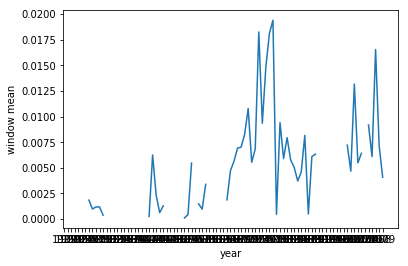

In [54]:
# позитивная разница со скользящим средним
plt.plot(rel_diff_window_mean.iloc[250,:])
plt.xlabel('year')
plt.ylabel('window mean')
# plt.title(window_mean_df.iloc[250, 1])

Text(0, 0.5, 'window mean')

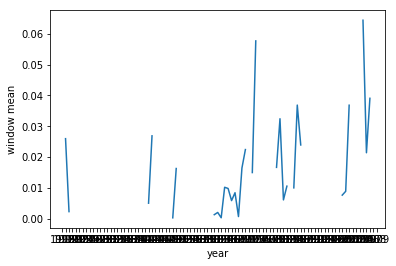

In [55]:
# позитивная разница без скользящего среднего
plt.plot(positive_rel_diff.iloc[250,:])
plt.xlabel('year')
plt.ylabel('window mean')
# plt.title(window_mean_df.iloc[250, 1])

# получается больше позитивного роста

In [56]:
# нормализуем
z_scores_window_mean = rel_diff_window_mean.apply(lambda ngram: 
                                             scale(ngram,
                                                   axis=0,
                                                   with_mean=True, 
                                                   with_std=True,
                                                   copy=False),
                                             axis=1)

In [57]:
z_scores_window_mean[250]

array([        nan,         nan,         nan,         nan,         nan,
       -0.917474  ,         nan,         nan, -0.76672141, -0.94853598,
       -0.9072393 , -0.90646583, -1.07624719,         nan, -0.07249432,
               nan,         nan,         nan, -0.93553914,         nan,
               nan,         nan, -1.08724221,         nan,         nan,
       -1.10143344,  0.15512186, -0.66440119, -1.02309251, -0.88581087,
               nan,         nan,         nan, -0.65883207,         nan,
       -1.13124356, -1.06338827, -0.01109281,         nan, -0.84408279,
       -0.9516755 , -0.44504496,         nan, -0.96495743,         nan,
       -0.99781639,         nan, -0.76179712, -0.1627994 ,  0.02879503,
        0.29738882,  0.31384789,  0.57574254,  1.10530397,  0.00632805,
        0.28058871,  2.67091229,  0.80426081,  1.95766178,  2.64116255,
        2.91061131, -1.05715039,  0.81842462,  0.08454826,  0.50970476,
        0.05517691, -0.09799535, -0.37668888, -0.1909878 ,  0.55

In [69]:
z_scores_window_mean_df = pd.DataFrame.from_records(z_scores_window_mean, 
                                                    columns = [str(i) for i in range(1918, 2009 + 1)])

In [70]:
z_scores_window_mean_df = z_scores_window_mean_df[z_scores_window_mean_df > 1.65] 

In [71]:
z_scores_window_mean_df = pd.concat([result_df.iloc[:, 0:2], 
                                     z_scores_window_mean_df, 
                                     result_df.iloc[:, -1]], axis=1)

In [74]:
z_scores_window_mean_df.head()

,index,unigram,1918,1919,1920,1921,1922,1923,1924,1925,...,2001,2002,2003,2004,2005,2006,2007,2008,2009,freq_sum
0,45054,для,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,224808916.0
1,68576,другой,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92584621.0
2,9525,два,NaN,NaN,NaN,NaN,NaN,NaN,2.955933,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56219235.0
3,20541,дело,NaN,NaN,NaN,NaN,NaN,5.298338,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52091655.0
4,1844,давать,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47745305.0


Text(0.5, 1.0, 'демографический')

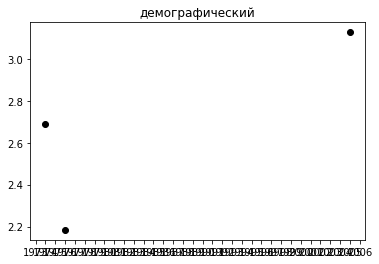

In [75]:
plt.plot(new_df_with_z_scores.iloc[250,2:-3], 'o', color='black')
plt.title(new_df_with_z_scores.iloc[250, 1])

Text(0.5, 1.0, 'демографический')

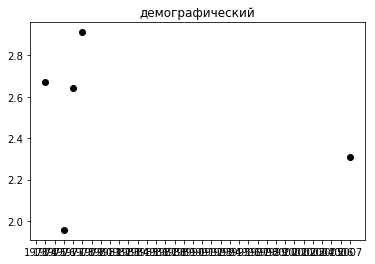

In [77]:
plt.plot(z_scores_window_mean_df.iloc[250, 2:-3], 'o', color='black')
plt.title(z_scores_window_mean_df.iloc[250, 1])

### Получилось больше интересных точек

# 5. Добавляем в словарь нграм интересующие нас даты

In [78]:
z_scores_window_mean_df.fillna(0, inplace=True)

In [143]:
unigrams = {i:[] for i in list(z_scores_window_mean_df.unigram)}

In [144]:
# добавим отдельные годы

for i in z_scores_window_mean_df.index:
    years_df = z_scores_window_mean_df.iloc[i, 2:-1][z_scores_window_mean_df.iloc[i, 2:-1] != 0]
    unigrams[z_scores_window_mean_df.iloc[i, 1]] = list(years_df.index)

In [145]:
# так выглядят годы, на которые приходится максимальный рост частотности
print(unigrams["друг"])
print(unigrams["демографический"])

['1941', '1942', '1945', '1997']
['1974', '1976', '1977', '1978', '2007']


In [94]:
# добавим периоды
# для этого посмотрим на относительные частоты без z-scores
rel_diff_window_mean.fillna(0, inplace=True)
rel_diff_window_mean_df = pd.concat([result_df.iloc[:, 0:2], 
                                     rel_diff_window_mean, 
                                     result_df.iloc[:, -1:]], axis=1)
rel_diff_window_mean_df.head()

year,index,unigram,1918,1919,1920,1921,1922,1923,1924,1925,...,2001,2002,2003,2004,2005,2006,2007,2008,2009,freq_sum
0,45054,для,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,-1.063409,0.000000,0.000000,0.0,224808916.0
1,68576,другой,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.960584,0.0,0.000000,0.000000,0.000000,0.0,92584621.0
2,9525,два,0.0,0.0,0.0,0.0,0.0,0.636830,2.955933,-0.336901,...,0.000000,0.000000,0.000000,-0.278538,0.0,0.000000,-0.767398,0.000000,0.0,56219235.0
3,20541,дело,0.0,0.0,0.0,0.0,0.0,5.298338,0.480420,0.174891,...,-0.623215,-0.058512,-0.207285,-0.446178,0.0,-0.686340,0.000000,-0.856757,0.0,52091655.0
4,1844,давать,0.0,0.0,0.0,0.0,0.0,-0.845364,0.000000,1.285166,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-0.955092,0.000000,0.0,47745305.0


In [146]:
for i in rel_diff_window_mean_df.index:
    
    target_years = []
    years_df = rel_diff_window_mean_df.iloc[i, 2:-1][rel_diff_window_mean_df.iloc[i, 2:-1] != 0]
    years = [int(i) for i in list(years_df.index)[::-1]]
    
    
    # код ниже позволяет объединить годы, 
    # где положительная разница относительных частот, 
    # в связки, и потом в периоды (с ... по ...)
    j = 0
    current_period = []
    while j < len(years)-1:
        if years[j] - years[j+1] == 1:
            current_period.append(years[j])
        elif years[j] - years[j+1] > 1:
            current_period.append(years[j])
            if current_period != []:
                target_years.append(current_period)
            current_period = []
        j += 1
    if j == len(years)-1:
        if current_period != [] and ( current_period[-1] - years[len(years)-1] == 1):
            current_period.append(years[len(years)-1])
            target_years.append(current_period)
            current_period = []
        else:
            current_period.append(years[len(years)-1])
    if current_period != []:
        target_years.append(current_period)  
                
    result_years = []
    
    for years in target_years:
        if len(years) > 1:
            start_year, end_year = years[-1], years[0]
            result_years.append([start_year, end_year])

    unigrams[rel_diff_window_mean_df.iloc[i, 1]].append(result_years)

In [149]:
unigrams["друг"]

['1941',
 '1942',
 '1945',
 '1997',
 [[2005, 2009],
  [1979, 1997],
  [1972, 1973],
  [1965, 1966],
  [1940, 1945],
  [1936, 1938]]]

In [150]:
unigrams["демографический"]

['1974',
 '1976',
 '1977',
 '1978',
 '2007',
 [[2005, 2009],
  [1999, 2003],
  [1965, 1990],
  [1957, 1959],
  [1953, 1955],
  [1943, 1947],
  [1926, 1930]]]